# The MattingMen Proudly Present: Image Matting, Neural and Classical

### Download the Dataset

In [ ]:
import gdown
from zipfile import ZipFile
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

def download_and_extract(zip_url, extract_to='./archive/', zip_path='temp.zip'):
    file_id = zip_url.split('/')[-2]
    drive_url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(drive_url, zip_path, quiet=False)
    
    with ZipFile(zip_path, 'r') as zip_ref: 
        zip_ref.extractall(extract_to)
    os.remove(zip_path)

google_drive_link = "https://drive.google.com/file/d/1ZWjgJ762I40bYn9DC9IDAsDbvwJ8Dqm5/view?usp=drive_link"
download_and_extract(google_drive_link)

#### Double Check That It's Working

In [1]:
def create_image_dataframe(root_dir):
    data = []
    
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if 'clip_' in subdir:
                image_type = 'clip'
            elif 'matting_' in subdir:
                image_type = 'matting'
            else:
                continue
                
            filename_without_extension = os.path.splitext(file)[0]
            full_path = os.path.join(subdir, file)
            
            data.append([filename_without_extension, full_path, image_type])
    
    df = pd.DataFrame(data, columns=['image_name', 'path', 'type'])
    return df

root_directory = './archive/'
image_df = create_image_dataframe(root_directory)

print(image_df.head())


            image_name                                               path  \
0  1803232244-00000010  ./archive/matting/1803232244/matting_00000000/...   
1  1803232244-00000428  ./archive/matting/1803232244/matting_00000000/...   
2  1803232244-00000372  ./archive/matting/1803232244/matting_00000000/...   
3  1803232244-00000399  ./archive/matting/1803232244/matting_00000000/...   
4  1803232244-00000158  ./archive/matting/1803232244/matting_00000000/...   

      type  
0  matting  
1  matting  
2  matting  
3  matting  
4  matting  


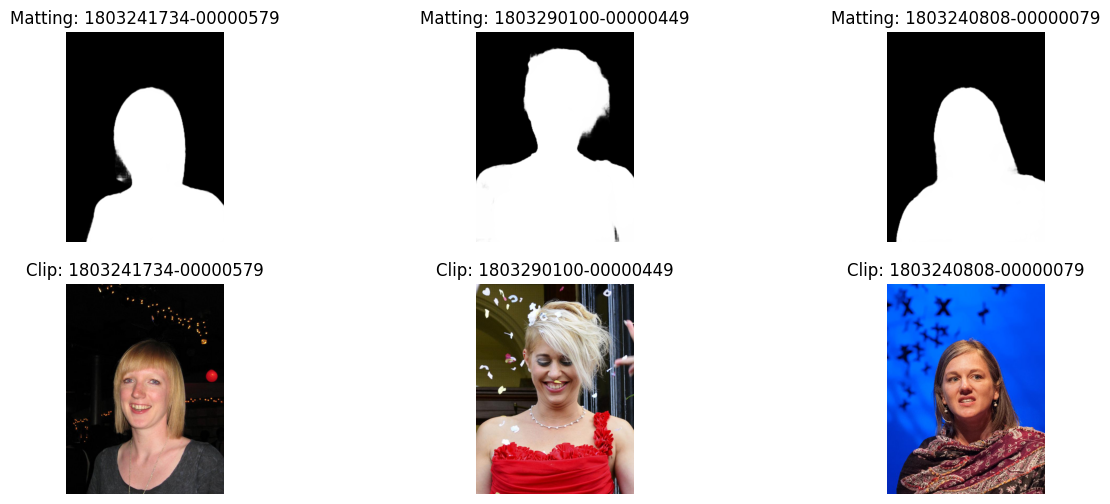

In [80]:
def display_image_pairs(df, num_images=3):
    matting_images = df[df['type'] == 'matting']
    clip_images = df[df['type'] == 'clip']
    
    selected_matting = matting_images.sample(n=num_images)
    
    _, axs = plt.subplots(2, num_images, figsize=(15, 6))
    
    for i, (_, row) in enumerate(selected_matting.iterrows()):
        matting_img = cv2.imread(row['path'], cv2.IMREAD_UNCHANGED)
        clip_row = clip_images[clip_images['image_name'] == row['image_name']].iloc[0]

        clip_img = cv2.imread(str(clip_row['path']))
        clip_img = cv2.cvtColor(clip_img, cv2.COLOR_BGR2RGB)
        
        axs[0, i].imshow(matting_img[:,:,3], cmap='gray')
        axs[0, i].set_title(f"Matting: {row['image_name']}")
        axs[0, i].axis('off')
        
        axs[1, i].imshow(clip_img)
        axs[1, i].set_title(f"Clip: {row['image_name']}")
        axs[1, i].axis('off')
    
    plt.show()

# Assume `image_df` is the DataFrame created previously
display_image_pairs(image_df, num_images=3)

def load_img(df, img_name):
    matting_images = df[df['type'] == 'matting']
    clip_images = df[df['type'] == 'clip']
    matting_row = matting_images[matting_images['image_name'] == img_name].iloc[0]
    clip_row = clip_images[clip_images['image_name'] == img_name].iloc[0]
    matting_img = cv2.imread(matting_row['path'], cv2.IMREAD_UNCHANGED)[:,:,3]
    clip_img = cv2.imread(str(clip_row['path']))
    clip_img = cv2.cvtColor(clip_img, cv2.COLOR_BGR2RGB)
    return matting_img, clip_img


# Practice Eroding Images

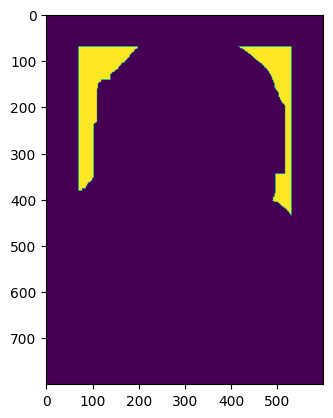

In [122]:
def backward_flood_fill(image, iterations=1, threshold=2):
    kernel = np.array([[1, 2, 1],
                       [2, 0, 2],
                       [1, 2, 1]], dtype=np.uint8)
    
    output_image = image.copy()
    
    for _ in range(iterations):
        neighbor_count = cv2.filter2D((output_image > 0).astype(np.uint8), -1, kernel, borderType=cv2.BORDER_CONSTANT)
        output_image[(neighbor_count < threshold) & (output_image > 0)] = 0
    
    return output_image

# Example usage:
# Load an image (replace 'path_to_image.png' with your actual image path)
matting, color = load_img(image_df, '1803280908-00000000')

# Apply the backward flood fill effect
result_image = backward_flood_fill(255-matting, iterations=70, threshold=6)

# Save or display the result
plt.imshow(result_image)